In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from statsmodels.tsa.stattools import acf, pacf

from drift_diffusion.model import DriftDiffusionModel

# preprocess dataframe
df196 = (
    utils.mat_to_pd("datasets/Rat196Vectors_241025.mat")
    .query("Valid == 1 and RT == RT")
    .assign(trialDate=lambda x: pd.to_datetime(x["trialDate"] - 719529, unit="D"))
    .set_index("trialDate")
    .sort_index()
    .assign(
        RT=lambda x: x["RT"] - x["RT"].min() + 1e-2,
        y=lambda x: x["RT"] * x["correct"].map({1: 1, 0: -1}),
        coh_bins=lambda x: pd.cut(x["coherence"], bins=5),
        day=lambda x: ((x.index - pd.Timedelta(hours=14)).floor("D") + pd.Timedelta(hours=14)),  # 2pm - 2pm
        hour=lambda x: x.index.hour + 1,
        minute5=lambda x: (x.index.hour * 12 + x.index.minute // 5),
    )
    .query("day == '2008-06-10 14:00:00'")  # max autocorrelation, 435 trial
)

print(df196.shape)

# fit DDM
ddm = DriftDiffusionModel(a="+1", t0=0, v="-1 + coherence", z=0, cov_estimator="autocorrelation-robust")
ddm.fit(df196, df196["y"])

(435, 21)


/var/folders/cy/gpl029fn5535gmz0p67pykhm0000gn/T/ipykernel_19886/3587983084.py:23: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  .query("day == '2008-06-10 14:00:00'")  # max autocorrelation, 435 trial


DriftDiffusionModel(cov_estimator='autocorrelation-robust', t0=0,
                    v='-1 + coherence', z=0)

Text(0.5, 1.0, 'score $\\beta_v$')

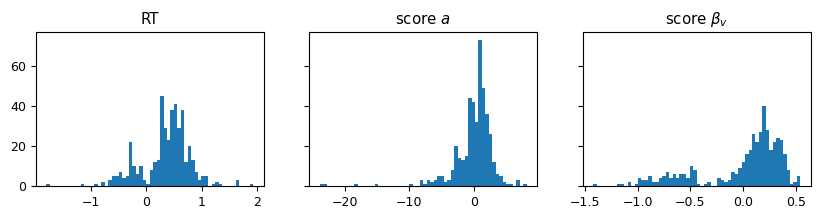

In [2]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 2), sharey=True)

axs[0].hist(df196["y"], bins=60)
axs[0].set_title("RT")
axs[1].hist(ddm.score_[:, 0], bins=60)
axs[1].set_title(r"score $a$")
axs[2].hist(ddm.score_[:, 1], bins=60)
axs[2].set_title(r"score $\beta_v$")

Text(0.5, 1.0, 'score $\\beta_v$')

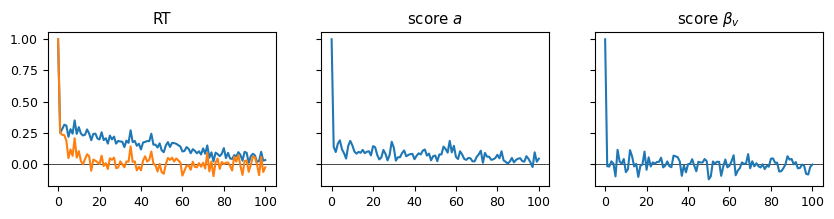

In [5]:
acf_kwargs = dict(nlags=100)

fig, axs = plt.subplots(ncols=3, figsize=(10, 2), sharey=True)
[ax.axhline(0, c="k", lw=0.5) for ax in axs]
axs[0].plot(acf(df196["RT"], **acf_kwargs))
axs[0].plot(pacf(df196["RT"], **acf_kwargs))
axs[0].set_title("RT")
axs[1].plot(acf(ddm.score_[:, 0], **acf_kwargs))
axs[1].set_title(r"score $a$")
axs[2].plot(acf(ddm.score_[:, 1], **acf_kwargs))
axs[2].set_title(r"score $\beta_v$")